Hydro-thermal power system planning problem: an introduction
================================================
The Brazilian interconnected power system have four regions, SE, S, N and NE, denoted by 0,1,2,3 for simiplicity. In each region, there are one integrated reserviour and several thermal plants to provide energy. Energy exchange is allowed between regions and an additional transshipment station. If demand can not be satisfied, a deficit cost will be incur. The objective is to minimize the total cost over the designing period meanwhile meeting energy requirements and feasibility constraints.

Notation
--------

$v_{it}$: stored energy in subsystem (reservior) $i$ at the beginning of stage $t$  
$a_{it}$: energy inflow in subsystem $i$ during stage $t$   
$q_{it}$: turbined energy (hydro generation) in subsystem $i$ during stage $t$  
$s_{it}$: spilled energy in subsystem $i$ during stage $t$  
$g_{kt}$: thermal generation at stage $t$ of thermal plants $k$ in each subsystem $i$ during stage $t$  
$\textrm{ex}_{i\rightarrow j,t}$: energy exchange from subsystem $i$ to subsystem $j$  
$\textrm{ex}_{j\rightarrow i,t}$: energy exchange from subsystem $j$ to subsystem $i$  
$\textrm{df}_{ijt}$: deficit account for subsystem $i$ in subsystem $j$ 

Formulation
----------------

Dynamics of each reservior $i$ is given by
\begin{equation*}
    v_{i,t+1} + s_{it} + q_{it} - v_{it} = a_{it}
\end{equation*}
Thermal plant generated energy and the hydro generated energy are the sources to satisfy demand. Energy can be exchanged between reserviors. Energy deficit will incur if demand can't be met. The supply-demand equation is thus
\begin{equation*}
    q_{it} + \sum_{k\in\omega_i} \textrm{g}_{kt} + \sum_{j} \textrm{df}_{ijt} -\sum_{j} \textrm{ex}_{i\rightarrow j,t} +\sum_{j} \textrm{ex}_{j\rightarrow i,t} = d_{it}
\end{equation*}
We assume there is no cost for hydro generation, $\$u_k$ for every megawatt thermal plant $k$ produces, $\$v_{ij}$ for every megawatt deficit account produces. Objective is to minimize energy generation cost (in thousands) over 12 months 
\begin{equation*}
    \sum_{t=1}^{12} \sum_i \big[\sum_k u_k g_{kt} + \sum_j v_{ij} \textrm{df}_{ijt}\big]
\end{equation*}

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from msppy.msp import MSLP
from msppy.solver import Extensive
from msppy.solver import SDDP
from msppy.evaluation import Evaluation
import gurobipy
import seaborn
seaborn.set_style('darkgrid')

Data
------

In [2]:
hydro_ = pandas.read_csv("./data/hydro.csv", index_col=0)
demand = pandas.read_csv("./data/demand.csv", index_col=0)
deficit_ = pandas.read_csv("./data/deficit.csv", index_col=0)
exchange_ub = pandas.read_csv("./data/exchange.csv", index_col=0)
exchange_cost = pandas.read_csv("./data/exchange_cost.csv", index_col=0)
thermal_ = [pandas.read_csv("./data/thermal_{}.csv".format(i), index_col=0) for i in range(4)]

The hydro_ dataframe gives the upper bounds of stored energy and hydro generation. It also gives the initial value of stored energy and inflow energy.

In [3]:
hydro_

,UB,INITIAL
StoredEnergy_0,200717.6,59419.3000
StoredEnergy_1,19617.2,5874.9000
StoredEnergy_2,51806.1,12859.2000
StoredEnergy_3,12744.9,5271.5000
inflow_0,0.0,39717.5640
inflow_1,0.0,6632.5141
inflow_2,0.0,15897.1830
inflow_3,0.0,2525.2938
hydro_0,45414.3,0.0000
hydro_1,13081.5,0.0000


thermal_ is a list containing four dataframes. Each dataframe provides LB, UB, Obj for each thermal plants in a specific region.

In [4]:
thermal_[0].head()

,LB,UB,OBJ
0,,,
0,520.0,657,21.49
1,1080.0,1350,18.96
2,0.0,36,937.00
3,59.3,250,194.79
4,27.1,250,222.22


demand is a dataframe of monthly demand in each region. Demand is assumed to be deterministic.

In [5]:
demand

,0,1,2,3
0,45515,11692,10811,6507
1,46611,11933,10683,6564
2,47134,12005,10727,6506
3,46429,11478,10589,6556
4,45622,11145,10389,6645
5,45366,11146,10129,6669
6,45477,11055,10157,6627
7,46149,11051,10372,6772
8,46336,10917,10675,6843
9,46551,11015,10934,6815


deficit_ dataframe gives the maximum deficit energy each region can afford and its related costs. For example, to meet the demand for region 0, the maximum deficit energy each region can afford is 5%, 5%, 10%, 80% respectively.

In [6]:
deficit_

,OBJ,DEPTH
0,1142.80,0.05
1,2465.40,0.05
2,5152.46,0.10
3,5845.54,0.80


The exchange_ub dataframe gives the upper bound of energy flows between four regions (0,1,2,3) and one transshipment station (4). Number 99999999 indicates no upper limit. The exchange_cost dataframe gives related costs.

In [7]:
exchange_ub

,0,1,2,3,4
0,0,7379,1000,0,4000
1,5625,0,0,0,0
2,600,0,0,0,2236
3,0,0,0,0,99999
4,3154,0,3951,3053,0


In [8]:
exchange_cost

,0,1,2,3,4
0,0.0000,0.0010,0.0010,0.0010,0.0005
1,0.0010,0.0000,0.0010,0.0010,0.0005
2,0.0010,0.0010,0.0000,0.0010,0.0005
3,0.0010,0.0010,0.0010,0.0000,0.0005
4,0.0005,0.0005,0.0005,0.0005,0.0000


Inflow modelling
---------------------

Inflow energy is assumed to be random. In this example, we use historical monthly data as scenarios.  
hist is a list containing four dataframes. Each dataframe gives historical monthly data for inflow energy.

In [9]:
hist = [pandas.read_csv("./data/hist_{}.csv".format(i), sep=";") for i in range(4)]

In [10]:
hist[0].head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1931,56896.80,86488.31,88646.94,64581.71,43078.74,32150.18,25738.04,20606.05,22772.16,23767.55,25831.89,38566.50
1,1932,56451.95,61922.34,50742.10,35954.27,27000.91,25285.24,19913.20,16801.72,15034.40,22347.14,25004.76,48755.60
2,1933,65408.16,51128.33,40424.25,34627.46,24456.72,19099.70,16790.67,14192.07,13741.74,17339.43,18503.66,36070.84
3,1934,46580.39,37113.35,35392.72,27179.93,19080.88,14173.57,11860.90,9904.96,11835.56,12925.78,13594.84,33700.23
4,1935,54645.97,72711.15,61323.17,54644.39,34731.77,26184.86,19927.38,19833.32,18289.43,34902.46,26176.69,32033.65


The following plot is the first 200 months inflow data for reservior one. It clearly shows a seasonality pattern. While in this tutorial we will pretend scenarios are stage-wise independent discrete.

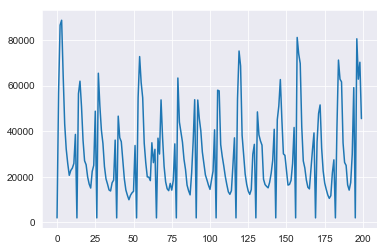

In [11]:
plt.plot(hist[0].values.flatten()[0:200])

Concatenate the four dataframes and remove NA

In [12]:
hist = pandas.concat(hist, axis=1)
hist.dropna(inplace=True)
hist.drop(columns='YEAR', inplace=True)

Each column of hist dataframe now gives scenarios of monthly inflow energy.

In [13]:
hist.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,...,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,56896.80,86488.31,88646.94,64581.71,43078.74,32150.18,25738.04,20606.05,22772.16,23767.55,...,23409.86,23382.44,10800.89,6555.49,4487.15,3223.12,2494.37,2569.03,4641.31,5928.45
1,56451.95,61922.34,50742.10,35954.27,27000.91,25285.24,19913.20,16801.72,15034.40,22347.14,...,14320.59,10803.52,6621.21,4734.66,3104.44,2097.61,1673.39,2055.48,3710.95,6305.46
2,65408.16,51128.33,40424.25,34627.46,24456.72,19099.70,16790.67,14192.07,13741.74,17339.43,...,13800.87,14378.16,9859.45,5247.05,3383.62,2428.81,1773.43,1617.70,4108.02,7741.12
3,46580.39,37113.35,35392.72,27179.93,19080.88,14173.57,11860.90,9904.96,11835.56,12925.78,...,14352.06,13302.03,10134.26,5947.45,3729.34,2481.26,1469.26,1797.54,2322.72,5572.98
4,54645.97,72711.15,61323.17,54644.39,34731.77,26184.86,19927.38,19833.32,18289.43,34902.46,...,18872.78,23222.27,15783.48,8962.09,5208.33,3864.63,2816.89,2790.11,4112.86,7840.01


 Disjoin scenarios for each regions.

In [14]:
scenarios = [hist.iloc[:,12*i:12*(i+1)].transpose().values for i in range(4)]

Solution
-----------

In [15]:
T = 3

In [16]:
HydroThermal = MSLP(T=T, bound=0, discount=0.9906)
for t in range(T):
    m = HydroThermal[t]
    stored_now, stored_past = m.addStateVars(4, ub=hydro_['UB'][:4], name="stored")
    spill = m.addVars(4, name="spill", obj=0.001)
    hydro = m.addVars(4, ub=hydro_['UB'][-4:], name="hydro")    
    deficit = m.addVars(
        [(i,j) for i in range(4) for j in range(4)], 
        ub = [demand.iloc[t%12][i] * deficit_['DEPTH'][j] for i in range(4) for j in range(4)],
        obj = [deficit_['OBJ'][j] for i in range(4) for j in range(4)], 
        name = "deficit")
    thermal = [None] * 4
    for i in range(4):
        thermal[i] = m.addVars(
            len(thermal_[i]), 
            ub=thermal_[i]['UB'], 
            lb=thermal_[i]['LB'], 
            obj=thermal_[i]['OBJ'], 
            name="thermal_{}".format(i)
        )
    exchange = m.addVars(5,5, obj=exchange_cost.values.flatten(),
        ub=exchange_ub.values.flatten(), name="exchange")    
    thermal_sum = m.addVars(4, name="thermal_sum")
    m.addConstrs(thermal_sum[i] == gurobipy.quicksum(thermal[i].values()) for i in range(4))
    
    for i in range(4): 
        m.addConstr(
            thermal_sum[i] 
            + gurobipy.quicksum(deficit[(i,j)] for j in range(4)) 
            + hydro[i] 
            - gurobipy.quicksum(exchange[(i,j)] for j in range(5))
            + gurobipy.quicksum(exchange[(j,i)] for j in range(5)) 
            == demand.iloc[t%12][i]
        )
    m.addConstr(
        gurobipy.quicksum(exchange[(j,4)] for j in range(5)) 
        - gurobipy.quicksum(exchange[(4,j)] for j in range(5)) 
        == 0
    )
    for i in range(4):
        if t == 0:
            m.addConstr(
                stored_now[i] + spill[i] + hydro[i] - stored_past[i] 
                == hydro_['INITIAL'][4:8][i]
            )
        else:
            m.addConstr(
                stored_now[i] + spill[i] + hydro[i] - stored_past[i] == 0, 
                uncertainty={'rhs': scenarios[i][t%12]}
            )
    if t == 0:
        m.addConstrs(stored_past[i] == hydro_['INITIAL'][:4][i] for i in range(4))

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [17]:
# Use the extensive solver
Extensive(HydroThermal).solve(outputFlag=0)

Academic license - for non-commercial use only


782309.1877977113

In [18]:
# Use the SDDP solver
HydroThermal_SDDP = SDDP(HydroThermal)
HydroThermal_SDDP.solve(logFile=0, n_processes=3, logToConsole=0, max_iterations=300)

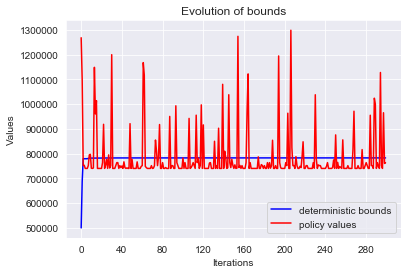

In [19]:
HydroThermal_SDDP.plot_bounds();

We now evaluate the policy by computing the policy values exhaustively for every scenarios. Suppose we are interested in solutions of hydro-generation. 

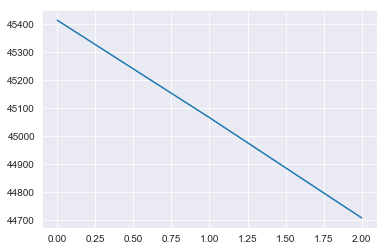

In [20]:
result = Evaluation(HydroThermal)
result.run(n_simulations=-1, query = ['hydro[{}]'.format(i) for i in range(4)])
%matplotlib inline
result.solution['hydro[0]'].mean().plot(legend = False)

epv is the exact value of the expected policy value. pv is the list of computed policy values.

In [22]:
result.gap, result.epv, numpy.std(result.pv)

(4.047462777712249e-07, 782309.0736226843, 96882.62071229359)